In [81]:
# The objective of the Costa Rican Household Poverty Level Prediction 
#is to develop a machine learning model that can predict the poverty level 
#of households using both individual and household characteristics. 

Problem and Data Explanation
The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

This is a supervised multi-class classification machine learning problem:

Supervised: provided with the labels for the training data
Multi-class classification: Labels are discrete values with 4 classes

Objective
The objective is to predict poverty on a household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0. We will cover how to correct this in the notebook (for more info take a look at the competition main discussion).

The Target values represent poverty levels as follows:

1 = extreme poverty 
2 = moderate poverty 
3 = vulnerable households 
4 = non vulnerable households

The explanations for all 143 columns can be found in the competition documentation, but a few to note are below:

Id: a unique identifier for each individual, this should not be a feature that we use!
idhogar: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
parentesco1: indicates if this person is the head of the household.
Target: the label, which should be equal for all members in a household
When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science job!

Metric
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the Macro F1 Score. You may be familiar with the standard F1 score for binary classification problems which is the harmonic mean of precision and recall:

F1=21recall+1precision=2⋅precision⋅recallprecision+recall
 
For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.

Macro F1=F1 Class 1+F1 Class 2+F1 Class 3+F1 Class 44
 
In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score). (For more information on the differences, look at the Scikit-Learn Documention for F1 Score or this Stack Exchange question and answers. If we want to assess our performance, we can use the code:

from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly.

Roadmap
The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. Our roadmap is therefore as follows:

Understand the problem (we're almost there already)
Exploratory Data Analysis
Feature engineering to create a dataset for machine learning
Compare several baseline machine learning models
Try more complex machine learning models
Optimize the selected model
Investigate model predictions in context of problem
Draw conclusions and lay out next steps
The steps laid out above are iterative meaning that while we will go through them one at a time, we might go back to an earlier step and revisit some of our decisions. In general, data science is a non-linear pracice where we are constantly evaluating our past decisions and making improvements. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time!

Getting Started
We have a pretty good grasp of the problem, so we'll move into the Exploratory Data Analysis (EDA) and feature engineering. For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures).

Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on!

With all that info in mind (don't worry if you haven't got all the details), let's get started!

In [236]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [238]:
#Read in Data and look at Summary Information
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0,100,1849,4
1,ID_f29eb3ddd,135000,0,4,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64,144,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64,121,8464,4
3,ID_d671db89c,180000,0,5,0,1,1,1,1,0,2,2,1,1,2,1,3,4,4,4,9,1,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1,121,289,4
4,ID_d56d6f5f5,180000,0,5,0,1,1,1,1,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1,121,1369,4


In [197]:
train.shape

(9557, 143)

In [198]:
test.shape

(23856, 142)

In [204]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000,0,4,0,1,1,1,1,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


In [255]:
Ids = train['Id'].unique()
Ids

array(['ID_279628684', 'ID_f29eb3ddd', 'ID_68de51c94', 'ID_d671db89c',
       'ID_d56d6f5f5', 'ID_ec05b1a7b', 'ID_e9e0c1100', 'ID_3e04e571e',
       'ID_1284f8aad', 'ID_51f52fdd2', 'ID_db44f5c59', 'ID_de822510c',
       'ID_d94071d7c', 'ID_064b57869', 'ID_5c837d8a4', 'ID_0a39e419e',
       'ID_4ff51f90c', 'ID_336c51386', 'ID_c51938edf', 'ID_35b66f7c6',
       'ID_74a2bc523', 'ID_15d393ce7', 'ID_a0bff0ba7', 'ID_848b0fdf1',
       'ID_298d857e5', 'ID_1d5bf8ddf', 'ID_e5cdba865', 'ID_e18530139',
       'ID_cba035c44', 'ID_b6c1c7e65', 'ID_96b1fbc81', 'ID_422226730',
       'ID_e24d9c3c9', 'ID_be1c0c929', 'ID_18ffaadc6', 'ID_beb36ce09',
       'ID_57b05a403', 'ID_01f1e94b3', 'ID_0f01e18e9', 'ID_e73a7a162',
       'ID_488b8ac27', 'ID_1f68e9b45', 'ID_e3869ade2', 'ID_451a7e35a',
       'ID_cf3c3d7ec', 'ID_feda408ee', 'ID_4dd2eaeba', 'ID_34d68201f',
       'ID_839160e1d', 'ID_340865cda', 'ID_eb1d477b3', 'ID_1edc6734e',
       'ID_68cdfd374', 'ID_be0fdb30f', 'ID_88d6dc9be', 'ID_e2d67d5bb',
      

In [4]:
train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2697.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,165231.606971,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.459791,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,0.677409,0.964738,0.031705,0.003558,0.885110,0.000314,0.002197,0.110809,0.003872,0.213979,0.764257,0.015381,0.002511,0.001883,0.489589,0.458407,0.050120,0.882704,0.03003,0.084545,0.001465,0,0.001256,0.102438,0.327404,0.570158,0.128388,0.288061,0.583551,0.101078,0.252799,0.646123,0.057549,0.483415,0.516585,0.137805,0.123260,0.268390,0.031914,0.062781,0.033169,0.342681,0.311081,0.184054,0.381814,0.012138,0.009522,0.051167,0.010045,0.002407,0.013289,0.003139,0.012661,0.008685,1.406613,2.592445,0.284085,3.999058,9.231523,0.134666,0.170556,0.207701,0.185414,0.112692,0.017893,0.015591,0.139793,0.015381,2.739981,1.605380,0.61850,0.10055

In [241]:
#Build a quick baseline Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Define input and output features
ytrain = train.iloc[:,-1] #Define target variable as last column of data frame (see https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
Xtrain = train.drop('Target', axis=1)

#Fill NAs
Xtrain = Xtrain.fillna(-999)

#label encoder
for c in train.columns[train.dtypes == 'object']:
    Xtrain[c] = Xtrain[c].factorize()[0]

rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [250]:
#Test the model

#Create a copy to work with
Xtest = test.copy()

#Save and drop labels
ytest = Xtrain
Xtest = Xtrain.iloc[0:141]

#Fill NAs
Xtest = Xtest.fillna(-999)

#Make the prediction
ypredictions = rf.predict(ytest)

In [253]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')

=== Confusion Matrix ===
[[  49   37   26  134]
 [  35  141   67  294]
 [  21   66   60  223]
 [  68  179  148 1606]]


=== Classification Report ===
             precision    recall  f1-score   support

          1       0.28      0.20      0.23       246
          2       0.33      0.26      0.29       537
          3       0.20      0.16      0.18       370
          4       0.71      0.80      0.75      2001

avg / total       0.55      0.59      0.57      3154





In [105]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rf_random.fit(X_train, y_train)
# print results
print(rf_random.best_params_)

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 300}


In [108]:
#Random Forest Classifier Model Metrics

# Use the forest's predict method on the test data
predictions = rf.predict(Xtest)
# Calculate the absolute errors
errors = abs(predictions - ytest)

#Macro F1 Score is Model Evaluation Metric
from sklearn.metrics import f1_score

print("=== Macro F1 Score ===")
f1_score (ytrain, ypredictions, average='macro')

=== Macro F1 Score ===


0.9976441983959405

In [109]:
#Now add these tuned parameters to the model to see if we can improve results
rfc = RandomForestClassifier(n_estimators=1000, max_depth=300, max_features='auto')
rfc.fit(Xfeatures_train,yfeatures_train)
rfc_predict = rfc.predict(Xfeatures_test)

print("=== Macro F1 Score ===")
f1_score (ytrain, ypredictions, average='macro')

#Notice there is no change in the macro F1 score with hypertuned parameters.

=== Macro F1 Score ===


0.9976441983959405

More Exploratory Data Analysis - Feature Selection

NameError: name 'vertical' is not defined

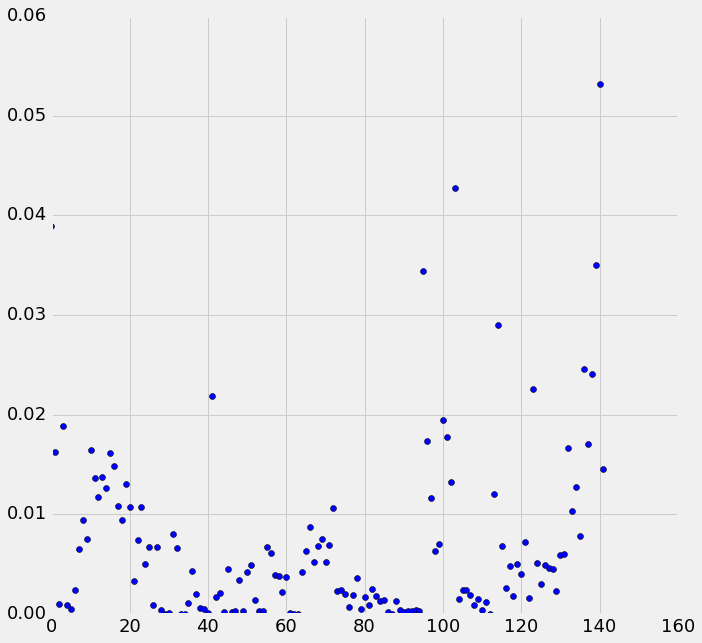

In [298]:
#Plot Feature Importance
plt.figure(figsize=(10,10)) #Increased figure size to see which features are most interesting
plt.plot(rf.feature_importances_, 'bo') #change to points to see individual feature points.
plt.xticks(np.arange(Xtrain.shape[1], Xtrain.columns.tolist, rotation=vertical))
plt.xlabel('Features')
plt.xlim(90,140)
plt.show()
#TLet's take a closer look at the outliers to see which features might affect the model the most.

In [299]:
#Combine first column with other most important features from new features training dataframe
train = train.iloc[:, [0,133,134,135,138,142]]
#These variables are probably the most important features in predicting the Target variable, y
#Preprocessed - intentionally left out Id column during training

#DELETE DUPLICATE FEATURES
#'SQBage' and 'agesq' are duplicates of 'age'
#'SQBedjefe', 'edjefe'[101] and 'SQBmeaned' are duplicate metrics of 'SQBescolari'
#'SQBhogar_nin' is duplicate metric of 'SQBhogar_total'
#Feature 93 is 'parentesco11' which does not appear to be relevant feature for model - delete
train.head()

,Id,SQBescolari,SQBage,SQBhogar_total,SQBovercrowding,Target
0,ID_279628684,100,1849,1,1.000000,4
1,ID_f29eb3ddd,144,4489,1,1.000000,4
2,ID_68de51c94,121,8464,1,0.250000,4
3,ID_d671db89c,81,289,16,1.777778,4
4,ID_d56d6f5f5,121,1369,16,1.777778,4


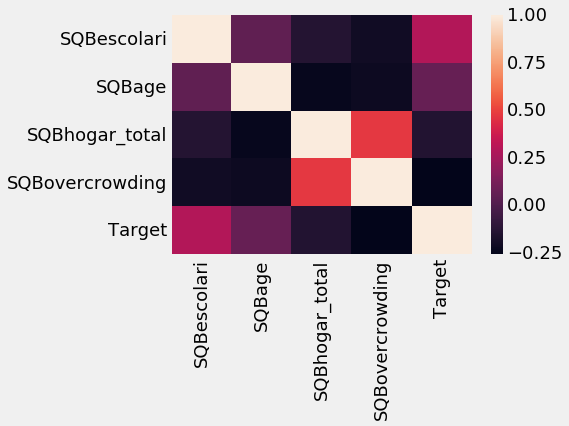

In [303]:
import seaborn as sns

#Calculate the correlation matrix
corr = train.corr()

#Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

#From the heatmap, we see'SQBovercrowding' has the highest correlation to the 'Target' at 0.50.
#SQBescolari is 0.25
#SQBhogar_total and SQBage have correlations between 0 and 0.25.

In [245]:
import numpy as np
np.set_printoptions(threshold=np.inf)  #https://stackoverflow.com/questions/1987694/how-to-print-the-full-numpy-array

print("-Here are the predicted Targets-")
ypredictions

-Here are the predicted Targets-


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [294]:
newdf = pd.DataFrame(ypredictions, Ids,columns=['Target'] )
newdf

,Target
ID_279628684,4
ID_f29eb3ddd,4
ID_68de51c94,4
ID_d671db89c,4
ID_d56d6f5f5,4
ID_ec05b1a7b,4
ID_e9e0c1100,4
ID_3e04e571e,4
ID_1284f8aad,4
ID_51f52fdd2,4


In [296]:
newdf.to_csv('CR_Kaggle_LKahn.csv')

In [297]:
#Read in Results Data
final = pd.read_csv('CR_Kaggle_LKahn.csv')
final.head(5)

,Id,Target
0,ID_279628684,4
1,ID_f29eb3ddd,4
2,ID_68de51c94,4
3,ID_d671db89c,4
4,ID_d56d6f5f5,4


In [144]:
#Next, let's try a NN to see if we can improve F1 macro score
from sklearn.neural_network import MLPClassifier

#Create a copy to work with
Xtrain = train.copy()

#Save and drop labels
ytrain = Xtrain.iloc[:,-1] #Define target variable as last column of data frame (see https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
Xtrain = Xtrain.drop('Target', axis=1)

#Fill NAs
Xtrain = Xtrain.fillna(-999)

#label encoder
for c in train.columns[train.dtypes == 'object']:
    Xtrain[c] = Xtrain[c].factorize()[0]

MLP= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2),random_state=1)
MLP.fit(Xtrain,ytrain)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [123]:
#Output Results in Desired Format
features.to_csv('CR_Kaggle_LKahn.csv, sep='\t',index='False')

SyntaxError: unexpected character after line continuation character (<ipython-input-123-c01e3da98752>, line 2)

In [76]:
#Feature Selection - Using Univariate Statistics
#https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#Define the attribute names
names = ['SQBescolari', 'hacdor', 'meaneduc','r4t3', 'SQBhogar_total','Target'] 
#These are variables based on domain knowledge, that may affect poverty predictor
#montly rent, #overcrowding by bedrooms, mean education, #people in household, square size of house

#Create pandas data frame by loading the data from URL
dataframe = pd.read_csv('train.csv', names=names)

#Convert all columns to float64
dataframe.apply(pd.to_numeric, errors='ignore').info()

#Create array from training data values
array = dataframe.values

C:\Users\lkahn\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,96,97,98,99,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9558 entries, (Id, v2a1, hacdor, rooms, hacapo, v14a, refrig, v18q, v18q1, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tamhog, tamviv, escolari, rez_esc, hhsize, paredblolad, paredzocalo, paredpreb, pareddes, paredmad, paredzinc, paredfibras, paredother, pisomoscer, pisocemento, pisoother, pisonatur, pisonotiene, pisomadera, techozinc, techoentrepiso, techocane, techootro, cielorazo, abastaguadentro, abastaguafuera, abastaguano, public, planpri, noelec, coopele, sanitario1, sanitario2, sanitario3, sanitario5, sanitario6, energcocinar1, energcocinar2, energcocinar3, energcocinar4, elimbasu1, elimbasu2, elimbasu3, elimbasu4, elimbasu5, elimbasu6, epared1, epared2, epared3, etecho1, etecho2, etecho3, eviv1, eviv2, eviv3, dis, male, female, estadocivil1, estadocivil2, estadocivil3, estadocivil4, estadocivil5, estadocivil6, estadocivil7, parentesco1, parentesco2, parentesco3, parentesco4, parentesco5, parentesco6, parentesco7, pare

In [77]:
#Split the data into input X and target Y

X = array[:,0:5]

Y = array[:,5]

#We will select the features using chi square

test = SelectKBest(score_func=chi2, k=4)

In [80]:
fit = test.fit(X, Y)
features = fit.transform(X)

ValueError: could not convert string to float: 'agesq'

In [30]:
#Test the Light Gradient Boosting Machine Algorithm
#https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/
#pip install lightgbm
import lightgbm as lgb
lgb = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

lgb.fit(X_train, Y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields idhogar

Exploring Label Distribution
Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where parentesco1 == 1 because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

1     222
2     442
3     355
4    1954
Name: Target, dtype: int64

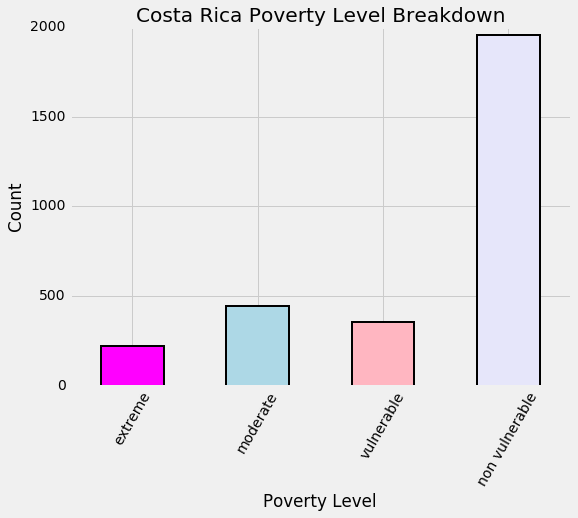

In [8]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'magenta', 2: 'lightblue', 3: 'lightpink', 4: 'lavender'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Costa Rica Poverty Level Breakdown');

label_counts

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the macro F1 score as the metric instead of weighted F1!). There are many more households that classify as non vulnerable than in any other category. The extreme poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifiying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling (which is covered in more advanced notebooks).

# Addressing Wrong Labels
As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because individuals in the same household have a different poverty level. We're not told why this may be the case, but we are told to use the head of household as the true label.

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason Why the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

Identify Errors
First we need to find the errors before we can correct them. To find the households with different labels for family members, we can group the data by the household and then check if there is only one unique value of the Target.

In [9]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [10]:
#Let's look at one example of a data error/ wrong label
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

#The organizers tell us that the correct label is that for the head of household, where parentesco1 == 1. For this household, the correct label is 3 for all members. 
#We can correct this (as shown later) by reassigning all the individuals in this household 
#the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself (or with the help of your team).

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


Families without Heads of Household
We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?"

Well, since you asked, let's investigate exactly that question!

In [11]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [12]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('There are {} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

There are 0 Households with no head have different labels.


Well that's a relief! This means that we don't have to worry about a household both where there is no head AND the members have different values of the label! For this problem, according to the organizers, if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training Nonetheless, it's still a good exercise to go through this process of investigating the data!

In [13]:
#Correct labels for households that have a head and the members have different poverty levels.
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


Since we are only going to use the heads of household for the labels, this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life. Don't consider it extra work, just practice for your career!

In [14]:
#Missing Variables
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


v18q1: Number of tablets

Let's start with v18q1 which indicates the number of tablets owned by a family. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.

Function to Plot Value Counts
Since we might want to plot value counts for different columns, we can write a simple function that will do it for us!

In [15]:
#Calculate null values for families that do not own a tablet
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

In [16]:
#Fill in missing values for 'v18q1' - own tablet column with 0
data['v18q1'] = data['v18q1'].fillna(0)

v2a1: Monthly rent payment

The next missing column is v2a1 which represents the montly rent payment.

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of tipovivi_, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

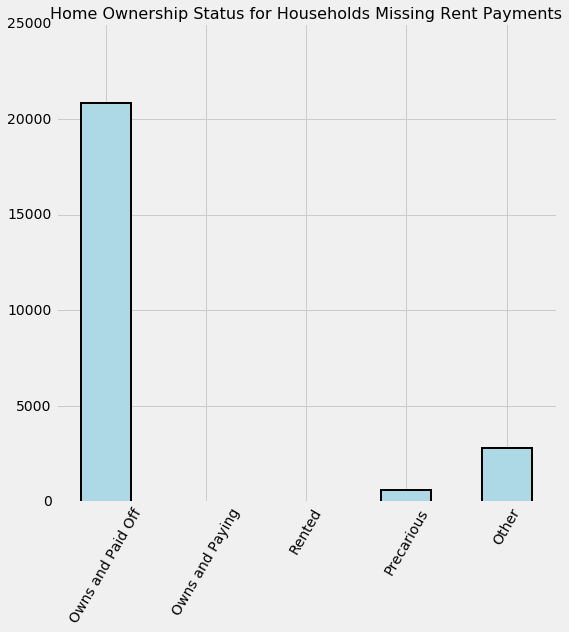

In [17]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (8, 8),
                                                                        color = 'lightblue',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 16);

The meaning of the home ownership variables is below:

tipovivi1, =1 own and fully paid house
tipovivi2, "=1 own,  paying in installments"
tipovivi3, =1 rented
tipovivi4, =1 precarious
tipovivi5, "=1 other(assigned,  borrowed)"

We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information.

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [18]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

rez_esc: years behind in school

The last column with a high percentage of missing values is rez_esc indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [19]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

In [20]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

If we read through some of the discussions for this competition, we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [21]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

There is also one outlier in the rez_esc column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

In [22]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

Plot Two Categorical Variables
To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

In [23]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

SyntaxError: invalid syntax (<ipython-input-23-36b58cad96c6>, line 33)

In [ ]:
plot_categoricals('rez_esc', 'Target', data);

In [ ]:
#Imputation - fill in missing values with the median of the column.
plot_value_counts(data[(data['v2a1-missing'] == 1)], 
                  'Target')

#Feature Engineering
There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.

Column Definitions
Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time. This is that part of the analysis: we have to define the columns that are at an individual level and at a household level using the data decsriptions. There is simply no other way to identify which variables at are the household level than to go through the variables themselves in the data description. Except, I've already done this for you, so all you have to do is copy and paste!

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.

The process is as follows

Break variables into household level and invididual level
Find suitable aggregations for the individual level data
Ordinal variables can use statistical aggregations
Boolean variables can also be aggregated but with fewer stats
Join the individual aggregations to the household level data
Define Variable Categories
There are several different categories of variables:

Individual Variables: these are characteristics of each individual rather than the household
Boolean: Yes or No (0 or 1)
Ordered Discrete: Integers with an ordering
Household variables
Boolean: Yes or No
Ordered Discrete: Integers with an ordering
Continuous numeric
Squared Variables: derived from squaring variables in the data
Id variables: identifies the data and should not be used as features
Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [ ]:
id_ = ['Id', 'idhogar', 'Target']

In [ ]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [ ]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [ ]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [ ]:
#Let's make sure we've covered all of the variables and didn't repeat any
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

Squared Variables
First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

In [ ]:
data = data.drop(['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'], axis=1)
data.shape

In [25]:
#Remove Redundant Household Variables with Correlation Matrrix
#Delete any variables with greater than 0.95 absolute magnitude correlation

# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['tamhog',
 'hhsize',
 'coopele',
 'female',
 'hogar_total',
 'meaneduc',
 'area2',
 'SQBescolari',
 'SQBage',
 'SQBdependency',
 'SQBmeaned',
 'agesq']

In [26]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,rez_esc,hhsize,hogar_total,SQBhogar_total
r4t3,1.000000,0.998287,0.910457,0.935585,0.998287,0.998287,0.944904
tamhog,0.998287,1.000000,0.909155,0.935585,1.000000,1.000000,0.946270
tamviv,0.910457,0.909155,1.000000,0.935585,0.909155,0.909155,0.866130
rez_esc,0.935585,0.935585,0.935585,1.000000,0.935585,0.935585,0.949596
hhsize,0.998287,1.000000,0.909155,0.935585,1.000000,1.000000,0.946270
hogar_total,0.998287,1.000000,0.909155,0.935585,1.000000,1.000000,0.946270
SQBhogar_total,0.944904,0.946270,0.866130,0.949596,0.946270,0.946270,1.000000


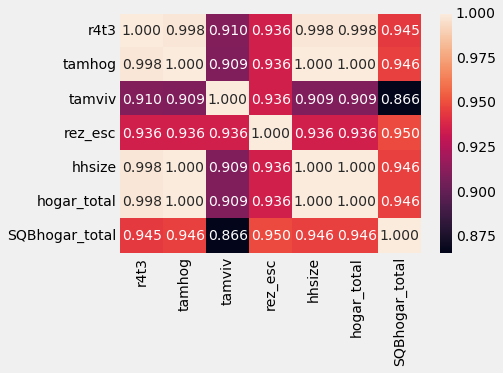

In [27]:
#View the results
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True,  fmt='.3f');

There are several variables here having to do with the size of the house:

r4t3, Total persons in the household
tamhog, size of the household
tamviv, number of persons living in the household
hhsize, household size
hogar_total, # of total individuals in the household
These variables are all highly correlated with one another. In fact, hhsize has a perfect correlation with tamhog and hogar_total. We will remove these two variables because the information is redundant. We can also remove r4t3 because it has a near perfect correlation with hhsize.

tamviv is not necessarily the same as hhsize because there might be family members that are not living in the household. Let's visualize this difference in a scatterplot.

In [28]:
heads = heads.drop(['tamhog', 'hogar_total', 'r4t3'], axis=1)

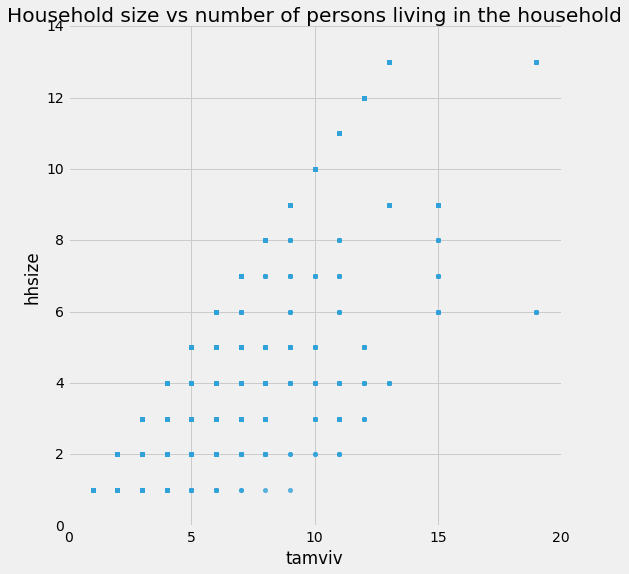

In [29]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

In [31]:
#Create a new feature - difference between number of people living in household and family
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

In [32]:
#Let's move on to the other redundant variables. First we can look at coopele
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

#These variables indicate where the electricity in the home is coming from. 
#There are four options, and the families that don't have one of these 
#two options either have no electricity (noelec) or get it from a private plant (planpri).

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


In [47]:
#Creating Ordinal Variable

#I'm going to compress these four variables into one 
#by creating an ordinal variable. I'm going to choose the mapping myself, 
#based on the data decriptions:
#0: No electricity
#1: Electricity from cooperative
#2: Electricity from CNFL, ICA, ESPH/JASEC
#3: Electricity from private plant

#An ordered variable has an inherent ordering, and for this we 
#choose our own based on the domain knowledge. 
#After we create this new ordered variable, we can drop the four others. 
#There are several households that do not have a variable here, so we will 
#use a nan (which will be filled in during imputation) and add a Boolean 
#column indicating there was no measure for this variable.


elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [51]:
heads = heads.drop(['area2'], axis=1, inplace=True)

AttributeError: 'NoneType' object has no attribute 'drop'

In [52]:

heads.groupby('area1')['Target'].value_counts(normalize = True)

#It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).


AttributeError: 'NoneType' object has no attribute 'groupby'

In [55]:
#Creating Ordinal Variables

#For the walls, roof, and floor of the house, there are three columns each: 
#the first indicating 'bad', the second 'regular', and the third 'good'. 
#We could leave the variables as booleans, but to me it makes more sense to 
#turn them into ordinal variables because there is an inherent order: bad < regular < good. 
#To do this, we can simply find whichever column is non-zero for each household using np.argmax.

#Once we have created the ordinal variable, we are able to drop the original variables.
# Wall ordinal variable
heads_walls = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

TypeError: 'NoneType' object is not subscriptable

In [54]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

TypeError: 'NoneType' object is not subscriptable

In [56]:
#FEATURE CONSTRUCTION
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.

In [3]:
#Code from: https://www.kaggle.com/luanho/simple-model-for-starter-0-413-lb
import numpy as np 
import pandas as pd 
import os
import gc
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder

In [4]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
#Look at training data
print(train.shape)
train.head()

(9557, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1321,0,1,0,1,36,0,20,10,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0,100,1849,4
1,ID_f29eb3ddd,135000,0,4,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,552,0,1,1,1,35,2,20,12,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64,144,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1767,0,1,1,1,35,20,1,11,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64,121,8464,4
3,ID_d671db89c,180000,0,5,0,1,1,1,1,0,2,2,1,1,2,1,3,4,4,4,9,1,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1717,2,2,0,4,37,1,20,11,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1,121,289,4
4,ID_d56d6f5f5,180000,0,5,0,1,1,1,1,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1717,2,2,0,4,37,1,20,11,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1,121,1369,4


In [7]:
#Look at test data
print(test.shape)
test.head()

(23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4581,1,2,0,3,10,20,7,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4581,1,2,0,3,10,20,7,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4581,1,2,0,3,10,20,7,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3667,0,1,0,1,36,6,20,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000,0,4,0,1,1,1,1,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1168,1,0,0,1,35,20,1,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


In [18]:
df_combine = pd.concat([train,test], axis = 0)
id_name = 'Id'
target_name = 'Target'
cols = [f_ for f_ in df_combine.columns if df_combine[f_].dtype == 'object' and f_ != id_name ]
print(cols)

# Lable encoder
for col in tqdm(cols):
    lb = LabelEncoder()
    lb.fit(df_combine[col])
    train[col] = lb.transform(train[col].astype(str))
    test[col] = lb.transform(test[col].astype(str))
    
del lb
gc.collect()

['edjefa', 'edjefe', 'idhogar']


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]


TypeError: unorderable types: str() < float()

In [14]:
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms'] #monthly rent / number of rooms
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] #household size
    df['meaneduc'] = df['meaneduc']

extract_features(train)
extract_features(test)

In [16]:
cols_to_drop = [id_name ,target_name]
X_train = train.drop(cols_to_drop, axis = 1)
Y_train = train[target_name]
X_train.fillna(0)

#pip install lightgbm
import lightgbm as lgb
lgb = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

lgb.fit(X_train, Y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields idhogar, dependency